### 8 GeV Trigger Threshold
#### Omar Moreno,  SLAC National Accelerator Laboratory
---
##### Samples
* Signal: A' mass - 1, 10, 100, 1000 MeV
* Inclusive: 500,000 8 GeV 1 electron events

##### Detector 
v12

In [1]:
import warnings
warnings.filterwarnings("ignore")

import uproot4
import plot_utils as pu

import awkward1 as ak
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import mplhep

In [2]:
files = {
    "$m_{A'}$ = 1000 MeV": '8gev_signal_ana_1000mev.root',
    "$m_{A'}$ = 100 MeV": '8gev_signal_ana_100mev.root',
    "$m_{A'}$ = 10 MeV":'8gev_signal_ana_10mev.root',
    "$m_{A'}$ = 1 MeV": '8gev_signal_ana_1mev.root',
    "Inclusive" : '8gev_inc_ana.root',
}

ufiles = {}
recoil_ntuples = {}
trig_ntuples = {}

for key, value in files.items():
    ufiles[key] = uproot4.open(value)
    recoil_ntuples[key] = ufiles[key]['RecoilNtuple/Recoil'].arrays()
    trig_ntuples[key]   = ufiles[key]['RecoilNtuple/Trigger'].arrays()

In [3]:
colors = [ "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7" ]

def draw_overlay(ntuples, variable, x_min, x_max, bins, x_label):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10), facecolor='white')
    for i, (key, ntuple) in enumerate(ntuples.items()): 
        pu.draw_histogram1D(ax, ntuple[variable], x_min, x_max, bins, norm=1, 
                            edgecolor=colors[i], color=colors[i], errors=True, x_label=x_label, 
                            label=key, type='step')
    ax.set_yscale("log")
    ax.legend(loc=0)
    
    return ax

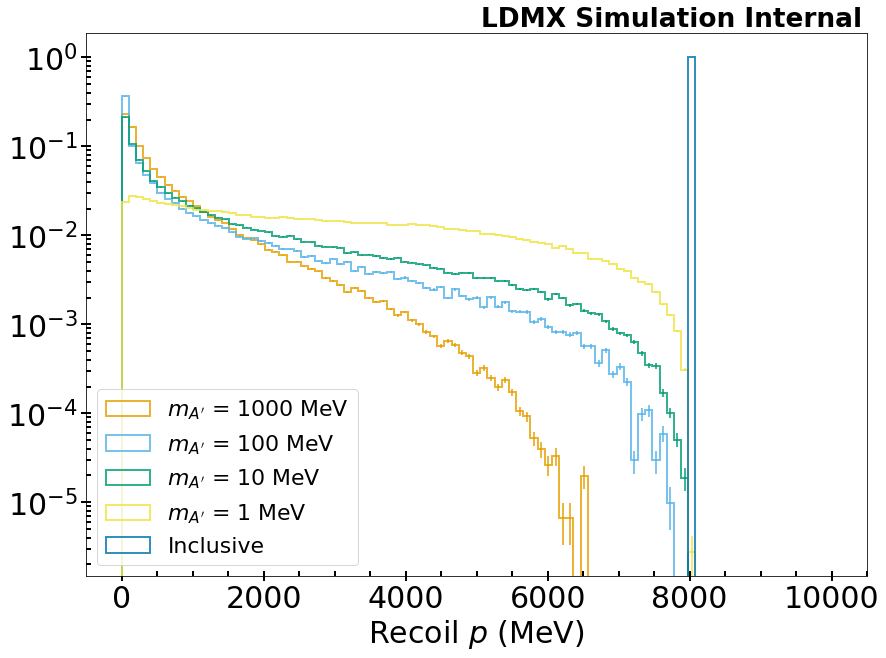

In [4]:
ax = draw_overlay(recoil_ntuples, 'recoil_p', 0, 10000, 100, 'Recoil $p$ (MeV)')
ax.legend(loc=3);

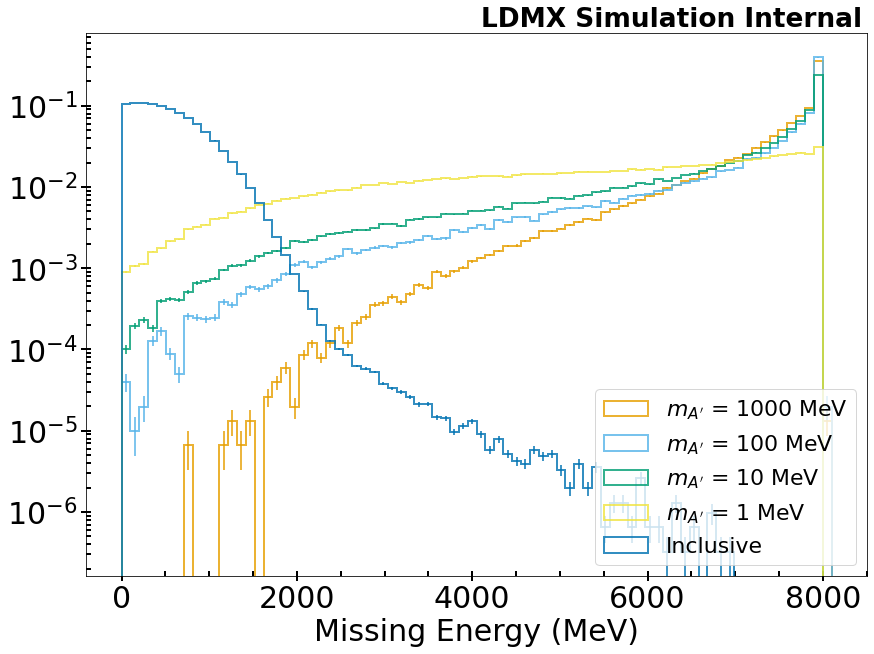

In [5]:
ax = draw_overlay(trig_ntuples, 'missing_energy', 0, 8100, 81, 'Missing Energy (MeV)')
ax.legend(loc=4);

In [6]:
eff = {}

for key, ntuple in trig_ntuples.items(): 
    eff[key] = { 'missing_energy': [], 'efficiency': [], 'count': []}
    for i in range(0, 8000, 20):
        
        n_events = len(ntuple['missing_energy'][ntuple['missing_energy'] > i])
        
        eff[key]['missing_energy'].append(i)
        eff[key]['efficiency'].append(n_events/len(ntuple['missing_energy']))
        eff[key]['count'].append(n_events)

for key, ntuple in eff.items(): 
    if key == "Inclusive": 
        eff[key]['sig'] = [] 
        continue
    eff[key]['sig'] = np.array(eff[key]['count'])/np.sqrt(np.array(eff[key]['count']) + np.array(eff['Inclusive']['count']))    

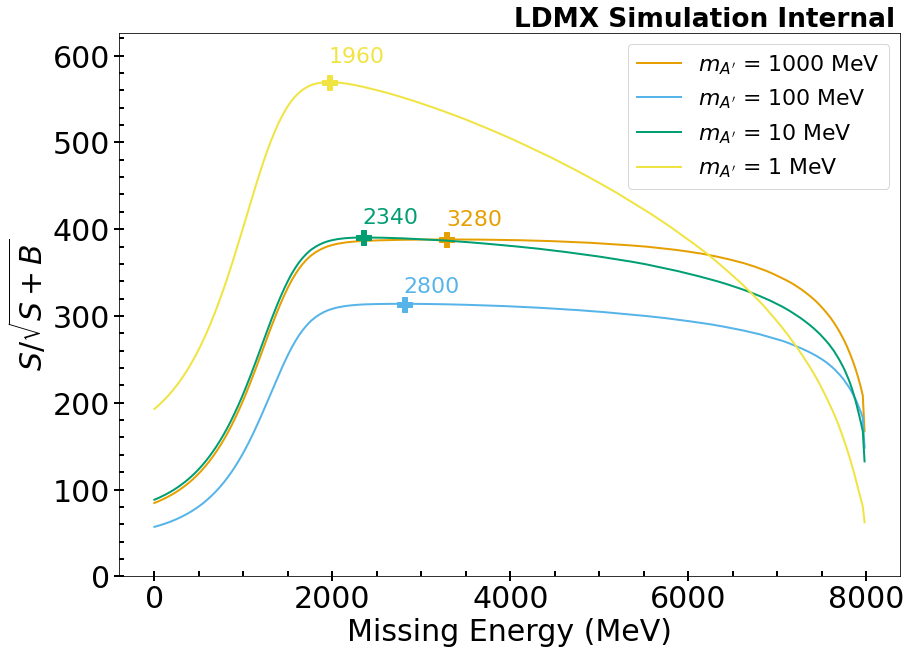

In [7]:
opt_thresh = {}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10), facecolor='white')
max_sig = 0
for i, (key, ntuple) in enumerate(eff.items()): 
    if key == "Inclusive": continue
    opt_thresh[key] = {}
    pu.draw_plot(ax, ntuple['missing_energy'], ntuple['sig'], 
                 x_label='Missing Energy (MeV)', y_label='$S/\sqrt{S + B}$',
                 label=key, color=colors[i])
    sig = np.amax(ntuple['sig'])
    max_sig = max(sig, max_sig)
    opt_thresh[key]['opt_index'] = np.argmax(ntuple['sig'])
    opt_thresh[key]['opt_missing_energy'] = ntuple['missing_energy'][opt_thresh[key]['opt_index']]
    ax.plot(opt_thresh[key]['opt_missing_energy'], sig, marker='P', 
            markersize=15, color=colors[i])
    ax.text(opt_thresh[key]['opt_missing_energy'], sig*1.04, 
            opt_thresh[key]['opt_missing_energy'], color=colors[i])

ax.set_ylim([0, max_sig*1.1])
ax.legend(loc=1);

Background Efficiency - $m_{A'}$ = 1000 MeV: 0.0001214
Trigger Rate (assuming mu=1):
 N(e) == 1: 1675.32 Hz
Background Efficiency - $m_{A'}$ = 100 MeV: 0.0002358
Trigger Rate (assuming mu=1):
 N(e) == 1: 3254.04 Hz
Background Efficiency - $m_{A'}$ = 10 MeV: 0.0004814
Trigger Rate (assuming mu=1):
 N(e) == 1: 6643.32 Hz
Background Efficiency - $m_{A'}$ = 1 MeV: 0.0014346
Trigger Rate (assuming mu=1):
 N(e) == 1: 19797.48 Hz

 === Scaling 4 GeV threshold (1500 --> 3000) ===
Trigger Rate (assuming mu = 1): 46.92 Hz
Efficiency - $m_{A'}$ = 1000 MeV: 0.9226789515655996 
Efficiency - $m_{A'}$ = 100 MeV: 0.8517347672368797 
Efficiency - $m_{A'}$ = 10 MeV: 0.7667296667296667 
Efficiency - $m_{A'}$ = 1 MeV: 0.419818100125862 


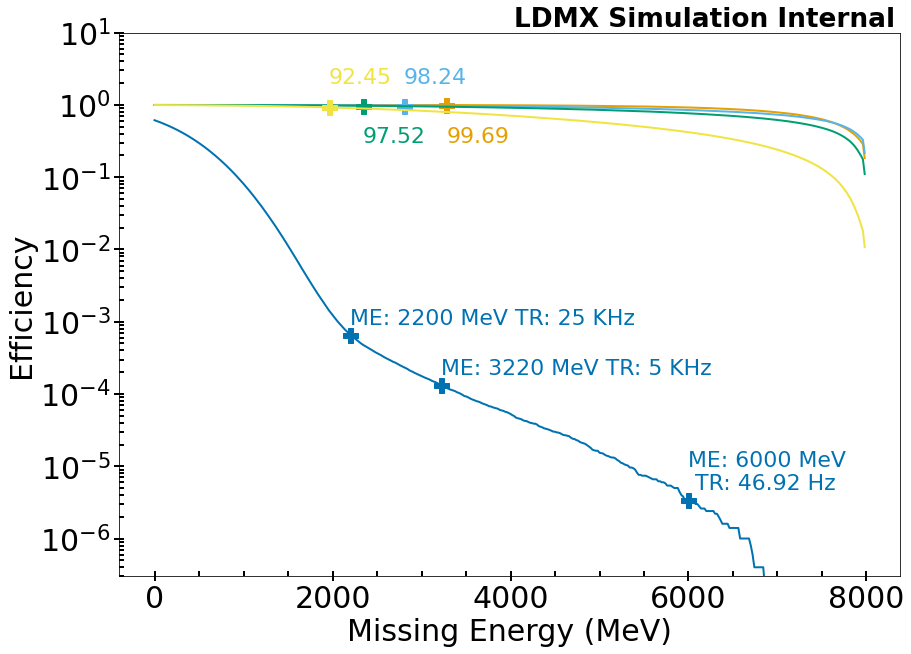

In [8]:
total_rate = 37500000

def get_min(ntuple, value): 
    min_diff = 1000
    min_diff_index = 0
    for i, j in enumerate(ntuple): 
        diff = abs(value - j)
        if diff < min_diff: 
            min_diff = diff
            min_diff_index = i
        
    return min_diff, min_diff_index
    
def get_eff_at_trig_rate(trig_rate): 
    max_eff = trig_rate/total_rate
    return get_min(eff['Inclusive']['efficiency'], max_eff)
    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10), facecolor='white')
pos = [0.3, 2, 0.3, 2 ]
for i, (key, ntuple) in enumerate(eff.items()): 
    pu.draw_plot(ax, ntuple['missing_energy'], ntuple['efficiency'],
                 x_label='Missing Energy (MeV)', y_label='Efficiency', 
                 label=key, color=colors[i])
    if key == "Inclusive": continue
    ax.plot(opt_thresh[key]['opt_missing_energy'], 
            ntuple['efficiency'][opt_thresh[key]['opt_index']], marker='P', 
            markersize=15, color=colors[i])
    ax.text(opt_thresh[key]['opt_missing_energy'],
            pos[i], 
            round(ntuple['efficiency'][opt_thresh[key]['opt_index']]*100, 2), 
            color=colors[i])


for key, ntuple in opt_thresh.items():  
    opt_eff = eff['Inclusive']['efficiency'][ntuple['opt_index']]
    print('Background Efficiency - %s: %s' % (key, opt_eff))
    trigger_rate = total_rate*opt_eff
    print('Trigger Rate (assuming mu=1):\n N(e) == 1: %s Hz' % (trigger_rate*.368))

min_diff, min_diff_index = get_eff_at_trig_rate(5000)

ax.plot(eff['Inclusive']['missing_energy'][min_diff_index], 
        eff['Inclusive']['efficiency'][min_diff_index], marker='P',
        markersize=15, color=colors[4])
ax.text(eff['Inclusive']['missing_energy'][min_diff_index], 
        eff['Inclusive']['efficiency'][min_diff_index]*1.4, 
        'ME: %s MeV TR: 5 KHz' % eff['Inclusive']['missing_energy'][min_diff_index],
        color=colors[4])

min_diff, min_diff_index = get_eff_at_trig_rate(25000)

ax.plot(eff['Inclusive']['missing_energy'][min_diff_index], 
        eff['Inclusive']['efficiency'][min_diff_index], marker='P',
        markersize=15, color=colors[4])
ax.text(eff['Inclusive']['missing_energy'][min_diff_index], 
        eff['Inclusive']['efficiency'][min_diff_index]*1.4, 
        'ME: %s MeV TR: 25 KHz' % eff['Inclusive']['missing_energy'][min_diff_index],
        color=colors[4])

print('\n === Scaling 4 GeV threshold (1500 --> 3000) ===')

min_diff, min_diff_index = get_min(eff['Inclusive']['missing_energy'], 6000)
rate = eff['Inclusive']['efficiency'][min_diff_index]
trig_rate = rate*.368*total_rate
print('Trigger Rate (assuming mu = 1): %s Hz' % trig_rate)
ax.plot(eff['Inclusive']['missing_energy'][min_diff_index], 
        eff['Inclusive']['efficiency'][min_diff_index], marker='P',
        markersize=15, color=colors[4])
ax.text(eff['Inclusive']['missing_energy'][min_diff_index], 
        eff['Inclusive']['efficiency'][min_diff_index]*1.4, 
        'ME: %s MeV\n TR: %s Hz' % (
            eff['Inclusive']['missing_energy'][min_diff_index], 
            trig_rate), 
        color=colors[4])

for key, ntuple in eff.items(): 
    if key == 'Inclusive': continue
    print('Efficiency - %s: %s ' % (
        key,
        ntuple['efficiency'][min_diff_index]))
    


ax.set_yscale("log")
ax.set_ylim([3e-7, 10]);